# Feature Importance

This notebook contains some boilerplate code for getting an early/simple estimation of feature importances for your variables.

Out of the various approaches, we will explore the code for two of them:
1. **Linear Regression**: Feature importance is determined by the absolute magnitude of the coefficients.
2. **Random Forest**: Feature importance is determined by the internal random forest feature_importance functionality. They are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree. There are other ways to get featuree importance using Random Forests, such as permutation-based feature importance, but we will focus on the most simple usecase below.

There are other approaches, such as SHAP, which may be added at a later date.

In [124]:
from datetime import datetime
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.decomposition import PCA, TruncatedSVD

## Generate Dummy Dataset for Regression

Below, we will generate a simple dummy dataset for regression, and split it into training and test data.

In [125]:
from sklearn.datasets import make_regression

# Generate test dataset and format for easy viewing
X, y = make_regression(n_samples = 1000, n_features = 15, n_informative = 10, noise = 50)
dataset = pd.DataFrame(X).add_prefix('x_')
dataset['y'] = y
dataset.head(3)

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,y
0,2.030919,0.549981,0.078371,-1.315037,-0.380408,0.628357,-1.172599,1.358490,0.310906,0.390199,-0.108681,0.053901,-2.133626,-0.189109,-3.076831,-152.924502
1,-1.187668,-0.213834,2.481378,1.123245,-0.693357,2.158473,0.307853,0.575358,-0.343087,0.515707,2.324003,-0.538950,-1.099098,1.625368,0.053685,515.893359
2,0.578677,-1.415827,0.721109,-0.501564,0.682680,0.229033,-1.282215,-0.663899,-0.253081,0.560307,-0.140561,0.312359,0.618874,-1.102907,1.420845,-21.803648


### Generate Training Data

Below, we create a very simple pipeline and train the linear model on the sample training data. We will then generate the feature importances using the **training data** only.

Note that in a real workflow, you will likely have to ensure that the dataset conforms to the Linear Regression model requirements. This involves generating dummy variables for categorical data, scaling the data, imputing, etc. Only some of those steps are included below.

In [126]:
# Create training, test splits using 80-20
X = dataset.drop(['y'], axis='columns')
y = dataset['y']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

print('Training Data Size: ', X_train.shape)
print('Test Data Size: ', X_test.shape)

Training Data Size:  (800, 15)
Test Data Size:  (200, 15)


## Feature Importance using Linear Regression

### Train the Linear Model and Obtain Coefficients

Now that we have the data prepared, we can run a pipeline to obtain feature weights.

In [127]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Create the pipeline
pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'), # Impute missing values based on the mean
                          StandardScaler(with_mean=False), # Standardize the columns to have mean 0 and unit variance
                          LinearRegression()) # Train the linear regression model on the data

# Fit the processed data to the training set
pipeline.fit(X_train, y_train)

# Create a dataframe of results
'''
feature: Feature Name
importance: importance metric generated by coefficients/random forest importance
absolute_importance: absolute value of importance (since linear regression coefficients can be negative)
importance_rank: rank of the importance value
'''
feature_coefficients = zip(pipeline['simpleimputer'].get_feature_names_out(),
                           pipeline['linearregression'].coef_)
df_feature_coef = pd.DataFrame(feature_coefficients, columns = ["feature", "importance"])
df_feature_coef['abs_importance'] = df_feature_coef['importance'].apply(lambda x: abs(x))
df_feature_coef['importance_rank'] = df_feature_coef['abs_importance'].rank(ascending=False).astype('int')
df_feature_coef = df_feature_coef.sort_values('importance_rank', ascending=True)
df_feature_coef.head(5)

,feature,importance,abs_importance,importance_rank
10,x_10,87.948553,87.948553,1
9,x_9,73.449332,73.449332,2
2,x_2,72.813465,72.813465,3
8,x_8,68.551785,68.551785,4
6,x_6,61.779517,61.779517,5


### Visualize Data

Below, we will graph the **top 10** out of 15 total variables in terms of feature importance. Note that in regression, the coefficients can be negative or positive, so we will rank them by **absolute** value.

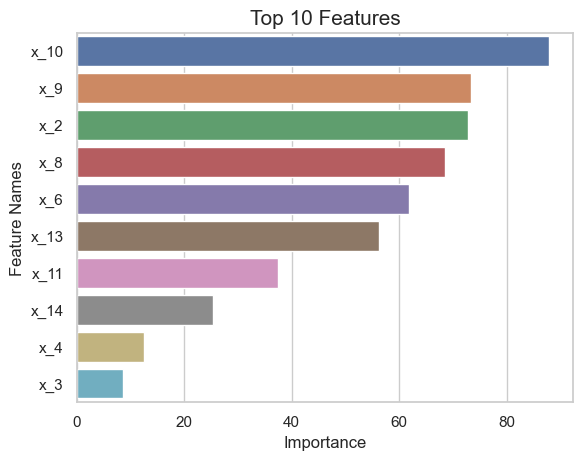

In [128]:
sns.barplot(x="abs_importance",
            y="feature",
            data=df_feature_coef.head(10))
plt.title("Top 10 Features", fontsize=15)
plt.ylabel("Feature Names")
plt.xlabel("Importance")
plt.show()

## Feature Importance using Random Forest Regressor

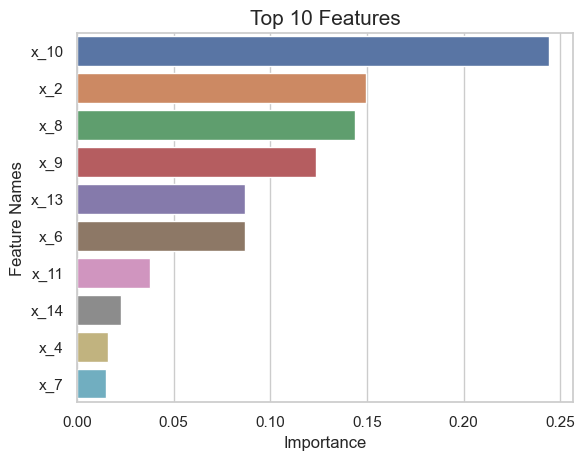

In [129]:
# linear regression feature importance
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
import seaborn as sns

# Make a pipeline, but ensure we have a linear regression defined first
pipeline = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                         RandomForestRegressor())

# Fit the model
pipeline.fit(X_train, y_train)

# Create a dataframe of results
'''
feature: Feature Name
importance: importance metric generated by coefficients/random forest importance
absolute_importance: absolute value of importance (since linear regression coefficients can be negative)
importance_rank: rank of the importance value
'''
feature_coefficients = zip(pipeline['simpleimputer'].get_feature_names_out(),
                           pipeline['randomforestregressor'].feature_importances_)
df_feature_coef = pd.DataFrame(feature_coefficients, columns = ["feature", "importance"])
df_feature_coef['abs_importance'] = df_feature_coef['importance'].apply(lambda x: abs(x))
df_feature_coef['importance_rank'] = df_feature_coef['abs_importance'].rank(ascending=False).astype('int')
df_feature_coef = df_feature_coef.sort_values('importance_rank', ascending=True)
df_feature_coef.head(5)

# Visualize the results
sns.barplot(x="abs_importance",
            y="feature",
            data=df_feature_coef.head(10))
plt.title("Top 10 Features", fontsize=15)
plt.ylabel("Feature Names")
plt.xlabel("Importance")
plt.show()